Fundamentos de ciência de dados - Luiz Davi e Thiago Cavalcanti

In [2]:
from constantes_jogadores import (
    JOGADOR_1_ID,
    JOGADOR_2_ID,
    JOGADOR_3_ID,
    JOGADOR_1,
    JOGADOR_2,
    JOGADOR_3,
    RESULTADOS_P2_PATH,
    RESULTADOS_PATH
)
import pandas as pd
from pygam import PoissonGAM, s, f
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, roc_curve, auc
import seaborn as sns

## RF7 – Prever uma quantidade X [pontos, rebotes, assistências] no próximo jogo. Use a função PoissonGAM e a função LinearGAM da biblioteca pygam.



Funções para processamento do modelo

In [3]:
def carregar_dados_carreira():
    return pd.read_csv(f"{RESULTADOS_P2_PATH}/rf9_estatisticas_de_toda_a_carreira.csv")


def carregar_dados_jogador(jogador_id):
    return pd.read_csv(f"{RESULTADOS_P2_PATH}/rf10_dados_carreira_{jogador_id}.csv")

def pre_processar_dados_jogador(dados_jogador):
    dados_jogador['PTS_per_game'] = dados_jogador['PTS'] / dados_jogador['GP']
    dados_jogador['REB_per_game'] = dados_jogador['REB'] / dados_jogador['GP']
    dados_jogador['AST_per_game'] = dados_jogador['AST'] / dados_jogador['GP']

    return dados_jogador


def features_modelagem(dados_jogador):
    X = dados_jogador[['PLAYER_AGE', 'MIN', 'FG_PCT', 'GP']].values
    y_pts = dados_jogador['PTS_per_game'].values
    y_reb = dados_jogador['REB_per_game'].values
    y_ast = dados_jogador['AST_per_game'].values

    return X, y_pts, y_reb, y_ast


def dividir_treino_teste(X, y_pts, y_reb, y_ast):

    X_train, X_test, y_train_pts, y_test_pts = train_test_split(X, y_pts, test_size=0.2, random_state=42)
    _, _, y_train_reb, y_test_reb = train_test_split(X, y_reb, test_size=0.2, random_state=42)
    _, _, y_train_ast, y_test_ast = train_test_split(X, y_ast, test_size=0.2, random_state=42)

    return X_train, X_test, y_train_pts, y_test_pts, y_train_reb, y_test_reb,y_train_ast, y_test_ast


def modelar(X_train, y_train_pts,  y_train_reb,y_train_ast):
    gam_pts = PoissonGAM(s(0) + s(1) + s(2) + s(3)).fit(X_train, y_train_pts)
    gam_reb = PoissonGAM(s(0) + s(1) + s(2) + s(3)).fit(X_train, y_train_reb)
    gam_ast = PoissonGAM(s(0) + s(1) + s(2) + s(3)).fit(X_train, y_train_ast)

    return gam_pts, gam_reb, gam_ast


def prever(X_test, gam_pts, gam_reb, gam_ast):
    y_pred_pts = gam_pts.predict(X_test)
    y_pred_reb = gam_reb.predict(X_test)
    y_pred_ast = gam_ast.predict(X_test)

    return y_pred_pts, y_pred_reb, y_pred_ast


def avaliar_modelo(y_true, y_pred):
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))

    return mae, rmse

Funções para exibição de gráficos

In [4]:
def salvar_foto(plt, label, jogador, nome_grafico):
    output_path = f"{RESULTADOS_PATH}/graficos/GAMLSS_previsoes_{nome_grafico}_{label}_{jogador}.png"
    plt.savefig(output_path)
    plt.tight_layout()


# Comparação entre valores reais e previstos
def plot_real_vs_pred(y_true, y_pred, label, jogador):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.6, color="blue")
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel("Valores Reais")
    plt.ylabel("Valores Previstos")
    plt.title(f"Valores Reais vs Previstos ({label})")
    plt.grid(True)
    salvar_foto(plt, label, jogador, 'real_vs_pred')
    plt.show()



# Distribuição dos erros
def plot_error_distribution(y_true, y_pred, label, jogador):
    erros = y_true - y_pred
    plt.figure(figsize=(8, 6))
    sns.histplot(erros, kde=True, bins=30, color="purple")
    plt.axvline(0, color="red", linestyle="--", label="Erro = 0")
    plt.xlabel("Erro de Previsão (Real - Previsto)")
    plt.ylabel("Frequência")
    plt.title(f"Distribuição dos Erros de Previsão ({label})")
    plt.legend()
    plt.grid(True)
    salvar_foto(plt, label, jogador, 'error_distribution')
    plt.show()



#### Nikola Jokić

In [5]:
carreira = carregar_dados_carreira()
dados_jogador = carregar_dados_jogador(JOGADOR_1_ID)

dados_jogador = pre_processar_dados_jogador(dados_jogador)

X, y_pts, y_reb, y_ast = features_modelagem(dados_jogador)

X_train, X_test, y_train_pts, y_test_pts, y_train_reb, y_test_reb,y_train_ast, y_test_ast = dividir_treino_teste(X, y_pts, y_reb, y_ast)

gam_pts, gam_reb, gam_ast = modelar(X_train, y_train_pts,  y_train_reb,y_train_ast)

y_pred_pts, y_pred_reb, y_pred_ast = prever(X_test, gam_pts, gam_reb, gam_ast)

mae_pts, rmse_pts = avaliar_modelo(y_test_pts, y_pred_pts)
mae_reb, rmse_reb = avaliar_modelo(y_test_reb, y_pred_reb)
mae_ast, rmse_ast = avaliar_modelo(y_test_ast, y_pred_ast)

print(f"PTS - MAE: {mae_pts:.2f}, RMSE: {rmse_pts:.2f}")
print(f"REB - MAE: {mae_reb:.2f}, RMSE: {rmse_reb:.2f}")
print(f"AST - MAE: {mae_ast:.2f}, RMSE: {rmse_ast:.2f}")

PTS - MAE: 7.82, RMSE: 10.14
REB - MAE: 3.78, RMSE: 4.39
AST - MAE: 2.71, RMSE: 3.30


In [6]:
proximo_jogo = np.array([[29, 35, 0.58, 1]])  # Exemplo de entrada
pred_pts = gam_pts.predict(proximo_jogo)
pred_reb = gam_reb.predict(proximo_jogo)
pred_ast = gam_ast.predict(proximo_jogo)

print(f"Previsão para o próximo jogo: PTS={pred_pts[0]:.2f}, REB={pred_reb[0]:.2f}, AST={pred_ast[0]:.2f}")

Previsão para o próximo jogo: PTS=29.28, REB=15.34, AST=9.78


Gráficos

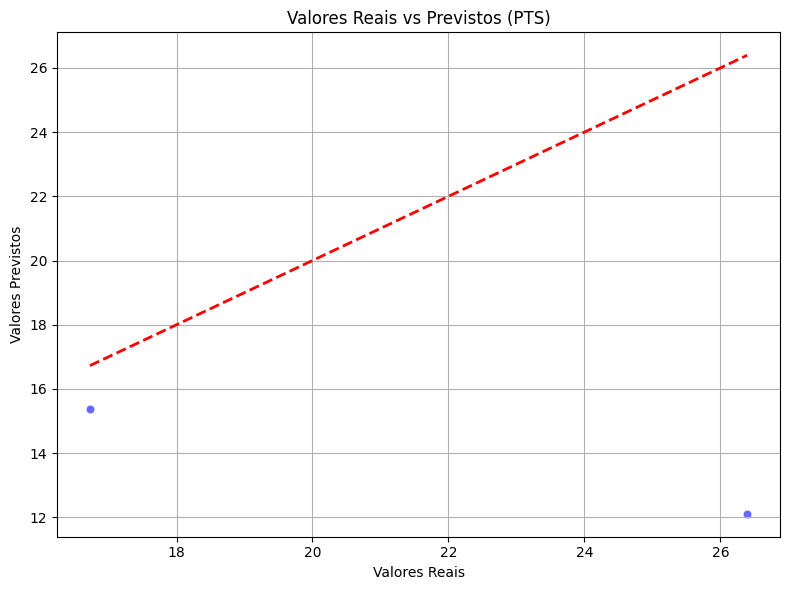

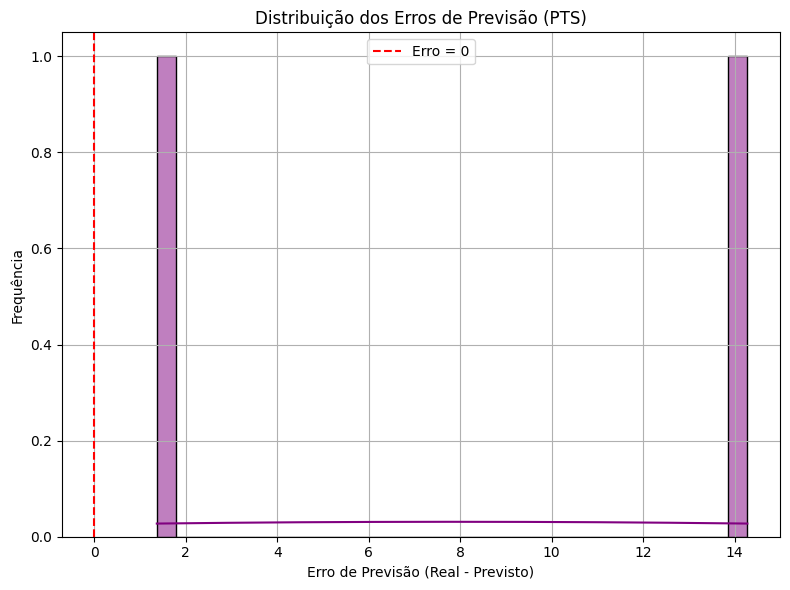

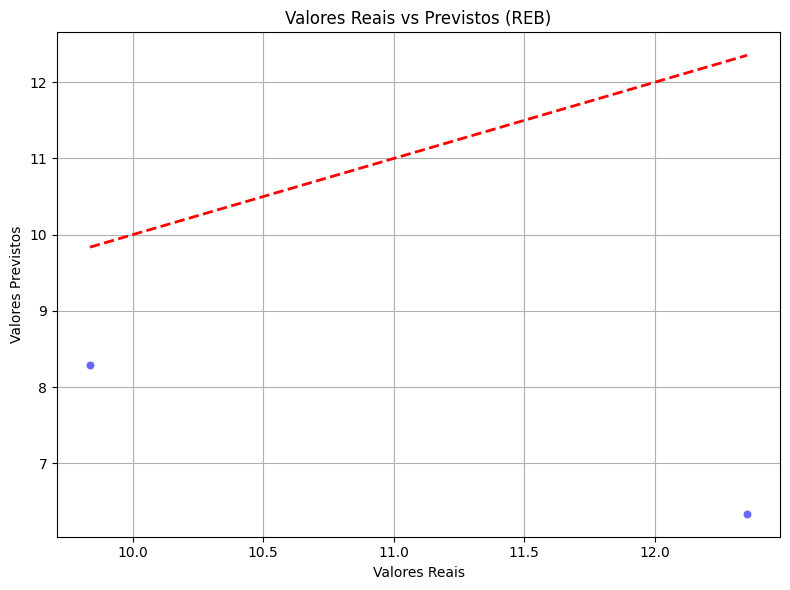

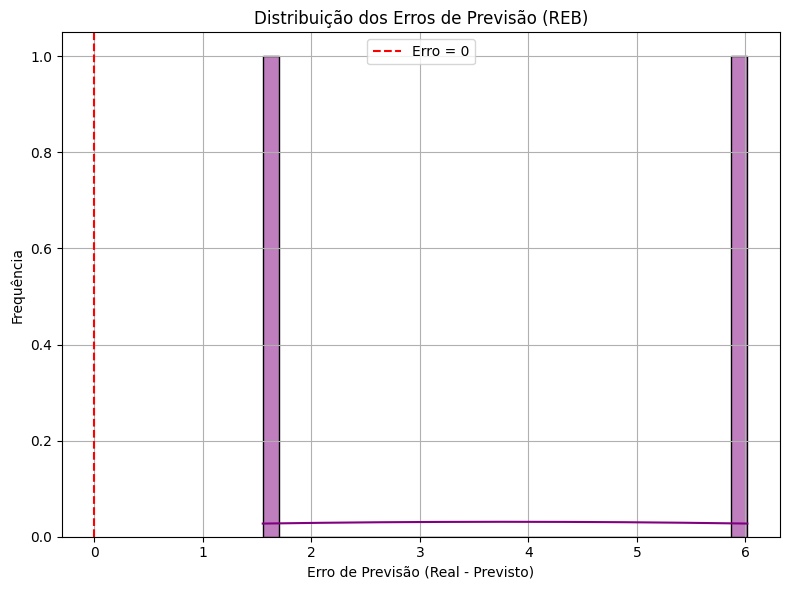

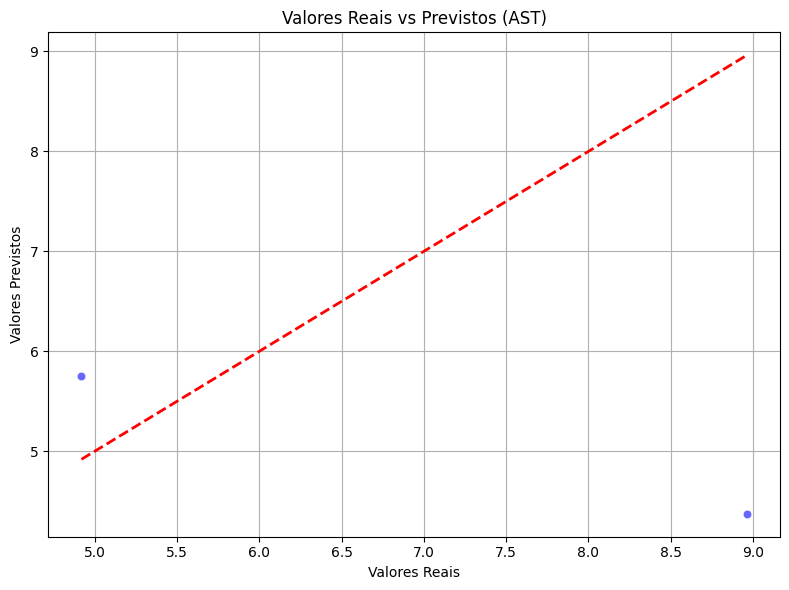

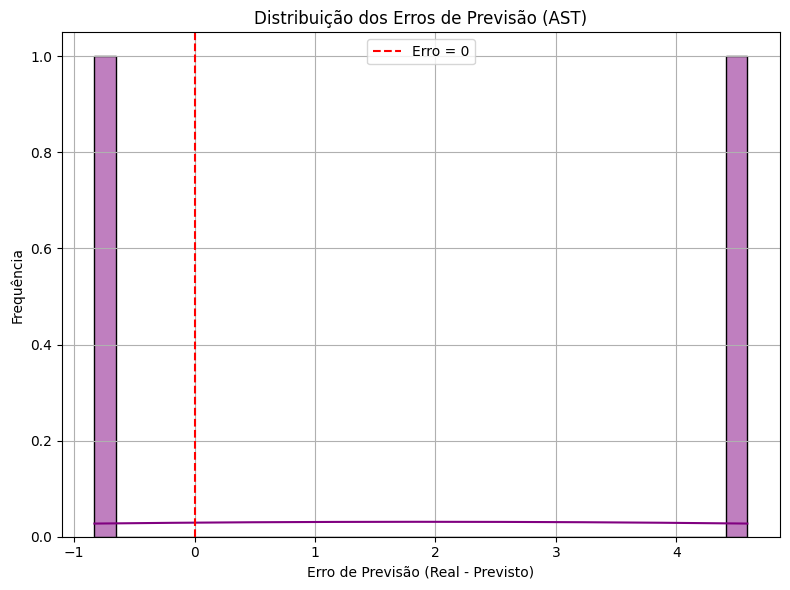

In [7]:
# Chamando as funções para cada métrica
feature_names = ['PLAYER_AGE', 'MIN', 'FG_PCT', 'GP']

# Gráficos para PTS
plot_real_vs_pred(y_test_pts, y_pred_pts, "PTS", JOGADOR_1)
plot_error_distribution(y_test_pts, y_pred_pts, "PTS", JOGADOR_1)


# Gráficos para REB
plot_real_vs_pred(y_test_reb, y_pred_reb, "REB", JOGADOR_1)
plot_error_distribution(y_test_reb, y_pred_reb, "REB", JOGADOR_1)


# Gráficos para AST
plot_real_vs_pred(y_test_ast, y_pred_ast, "AST", JOGADOR_1)
plot_error_distribution(y_test_ast, y_pred_ast, "AST", JOGADOR_1)


#### Michael Porter Jr.

In [8]:
carreira = carregar_dados_carreira()
dados_jogador = carregar_dados_jogador(JOGADOR_2_ID)

dados_jogador = pre_processar_dados_jogador(dados_jogador)

X, y_pts, y_reb, y_ast = features_modelagem(dados_jogador)

X_train, X_test, y_train_pts, y_test_pts, y_train_reb, y_test_reb,y_train_ast, y_test_ast = dividir_treino_teste(X, y_pts, y_reb, y_ast)

gam_pts, gam_reb, gam_ast = modelar(X_train, y_train_pts,  y_train_reb,y_train_ast)

y_pred_pts, y_pred_reb, y_pred_ast = prever(X_test, gam_pts, gam_reb, gam_ast)

mae_pts, rmse_pts = avaliar_modelo(y_test_pts, y_pred_pts)
mae_reb, rmse_reb = avaliar_modelo(y_test_reb, y_pred_reb)
mae_ast, rmse_ast = avaliar_modelo(y_test_ast, y_pred_ast)

print(f"PTS - MAE: {mae_pts:.2f}, RMSE: {rmse_pts:.2f}")
print(f"REB - MAE: {mae_reb:.2f}, RMSE: {rmse_reb:.2f}")
print(f"AST - MAE: {mae_ast:.2f}, RMSE: {rmse_ast:.2f}")

PTS - MAE: 3.95, RMSE: 5.10
REB - MAE: 1.05, RMSE: 1.41
AST - MAE: 0.40, RMSE: 0.43


In [9]:
proximo_jogo = np.array([[29, 35, 0.58, 1]])
pred_pts = gam_pts.predict(proximo_jogo)
pred_reb = gam_reb.predict(proximo_jogo)
pred_ast = gam_ast.predict(proximo_jogo)

print(f"Previsão para o próximo jogo: PTS={pred_pts[0]:.2f}, REB={pred_reb[0]:.2f}, AST={pred_ast[0]:.2f}")

Previsão para o próximo jogo: PTS=14.35, REB=7.03, AST=1.92


Gráficos

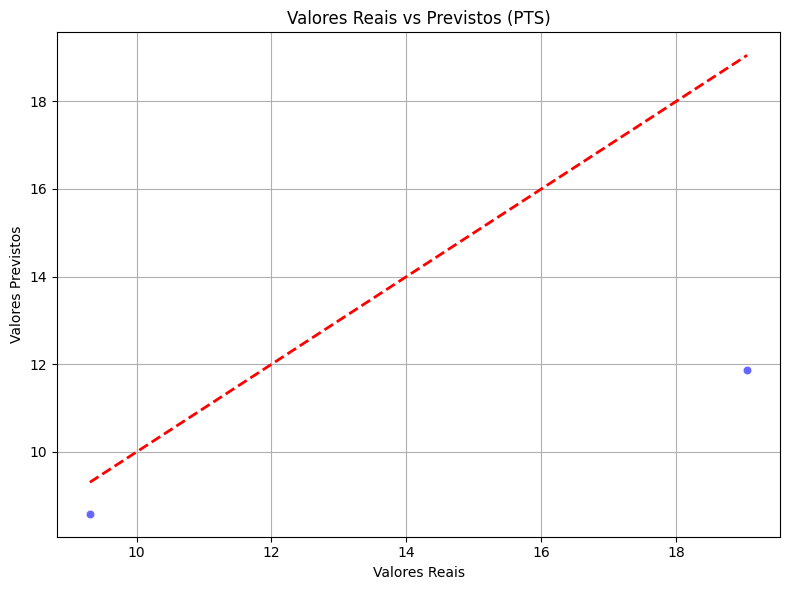

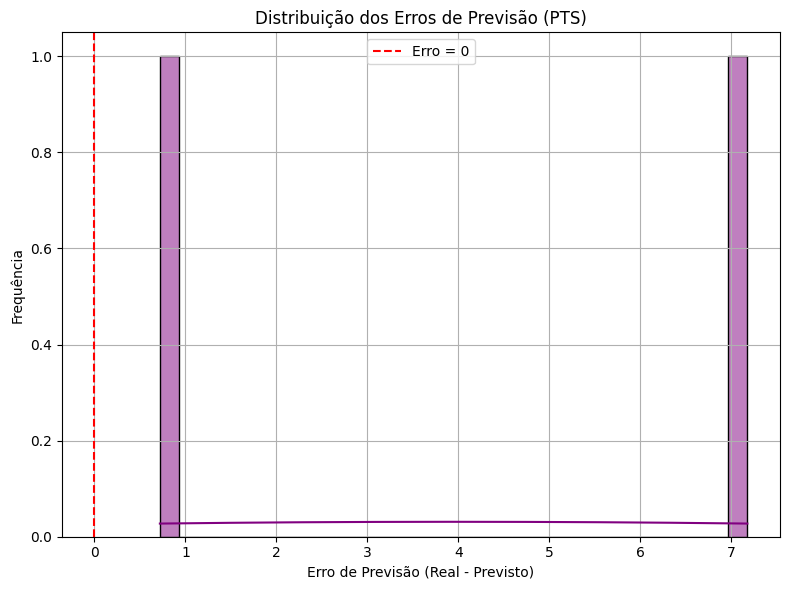

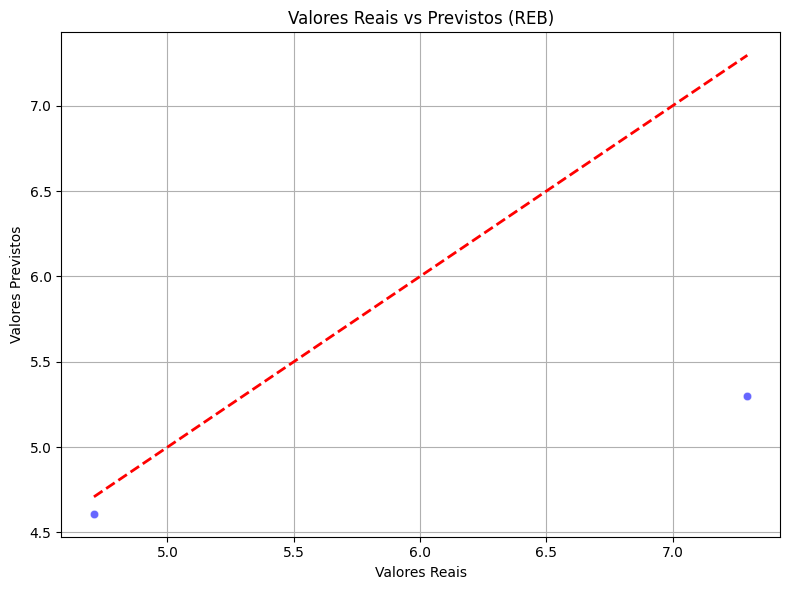

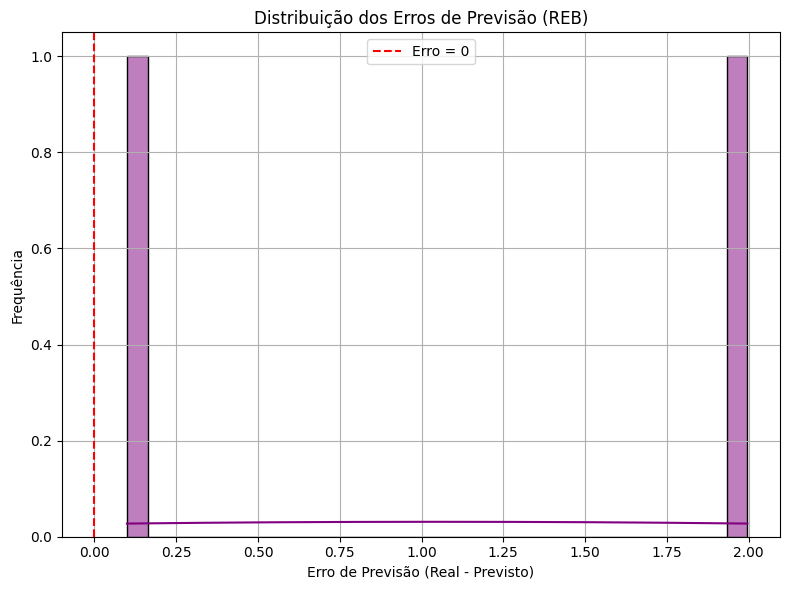

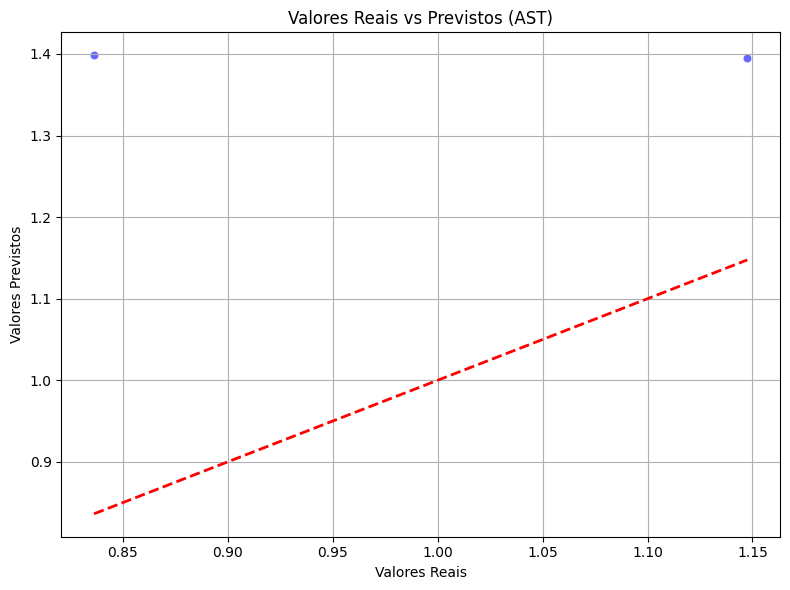

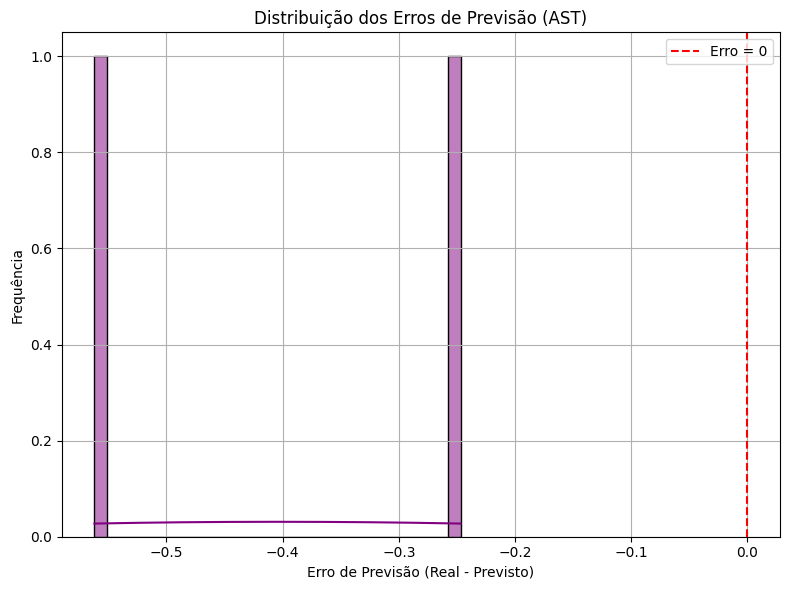

In [10]:
# Chamando as funções para cada métrica
feature_names = ['PLAYER_AGE', 'MIN', 'FG_PCT', 'GP']

# Gráficos para PTS
plot_real_vs_pred(y_test_pts, y_pred_pts, "PTS", JOGADOR_2)
plot_error_distribution(y_test_pts, y_pred_pts, "PTS", JOGADOR_2)


# Gráficos para REB
plot_real_vs_pred(y_test_reb, y_pred_reb, "REB", JOGADOR_2)
plot_error_distribution(y_test_reb, y_pred_reb, "REB", JOGADOR_2)


# Gráficos para AST
plot_real_vs_pred(y_test_ast, y_pred_ast, "AST", JOGADOR_2)
plot_error_distribution(y_test_ast, y_pred_ast, "AST", JOGADOR_2)


#### Jamal Murray

In [11]:
carreira = carregar_dados_carreira()
dados_jogador = carregar_dados_jogador(JOGADOR_3_ID)

dados_jogador = pre_processar_dados_jogador(dados_jogador)

X, y_pts, y_reb, y_ast = features_modelagem(dados_jogador)

X_train, X_test, y_train_pts, y_test_pts, y_train_reb, y_test_reb,y_train_ast, y_test_ast = dividir_treino_teste(X, y_pts, y_reb, y_ast)

gam_pts, gam_reb, gam_ast = modelar(X_train, y_train_pts,  y_train_reb,y_train_ast)

y_pred_pts, y_pred_reb, y_pred_ast = prever(X_test, gam_pts, gam_reb, gam_ast)

mae_pts, rmse_pts = avaliar_modelo(y_test_pts, y_pred_pts)
mae_reb, rmse_reb = avaliar_modelo(y_test_reb, y_pred_reb)
mae_ast, rmse_ast = avaliar_modelo(y_test_ast, y_pred_ast)

print(f"PTS - MAE: {mae_pts:.2f}, RMSE: {rmse_pts:.2f}")
print(f"REB - MAE: {mae_reb:.2f}, RMSE: {rmse_reb:.2f}")
print(f"AST - MAE: {mae_ast:.2f}, RMSE: {rmse_ast:.2f}")

PTS - MAE: 8.65, RMSE: 9.00
REB - MAE: 1.00, RMSE: 1.04
AST - MAE: 1.54, RMSE: 2.15


In [12]:
proximo_jogo = np.array([[29, 35, 0.58, 1]])
pred_pts = gam_pts.predict(proximo_jogo)
pred_reb = gam_reb.predict(proximo_jogo)
pred_ast = gam_ast.predict(proximo_jogo)

print(f"Previsão para o próximo jogo: PTS={pred_pts[0]:.2f}, REB={pred_reb[0]:.2f}, AST={pred_ast[0]:.2f}")

Previsão para o próximo jogo: PTS=0.44, REB=0.96, AST=1.49


Gráficos

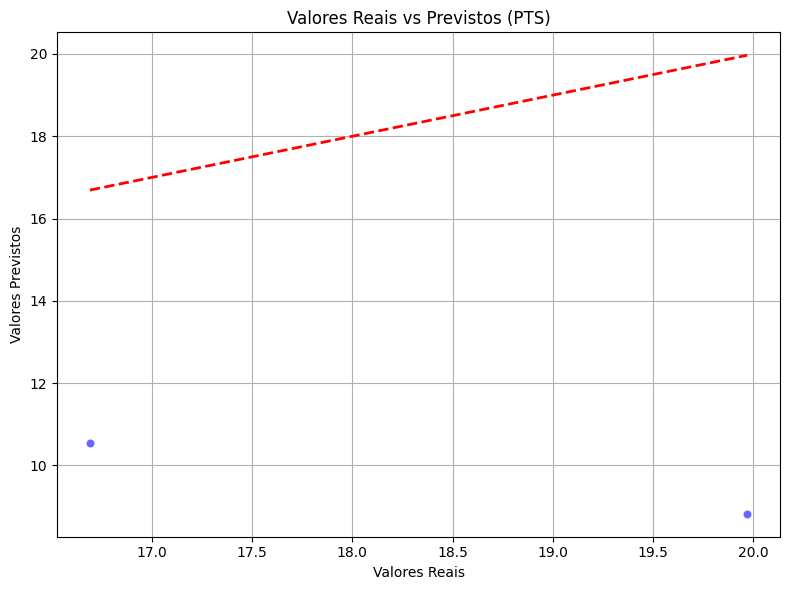

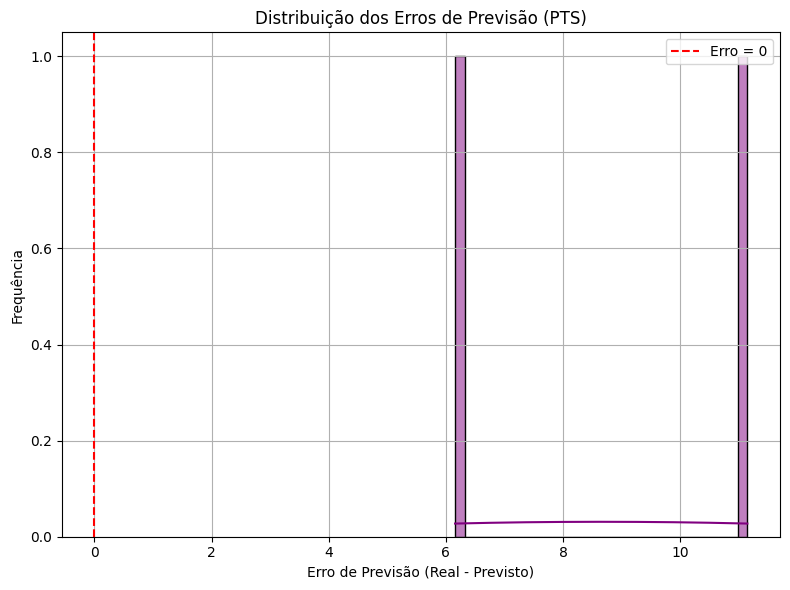

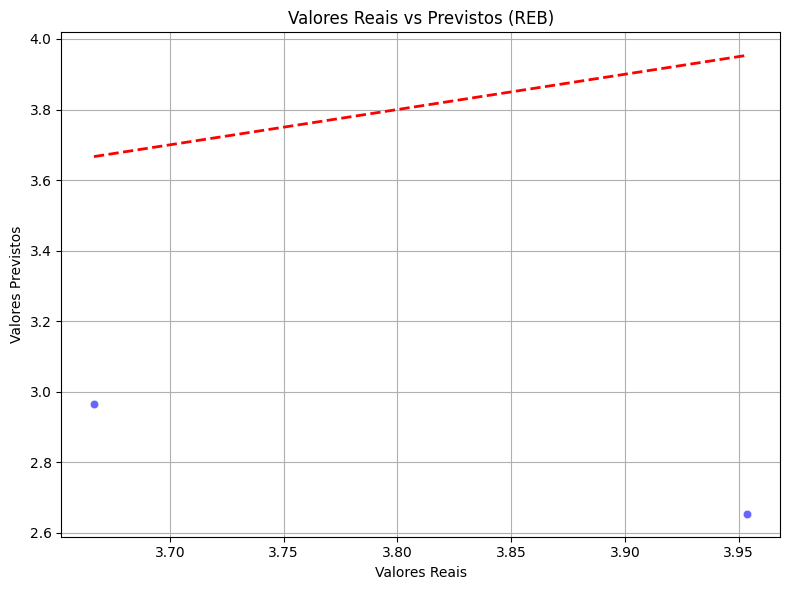

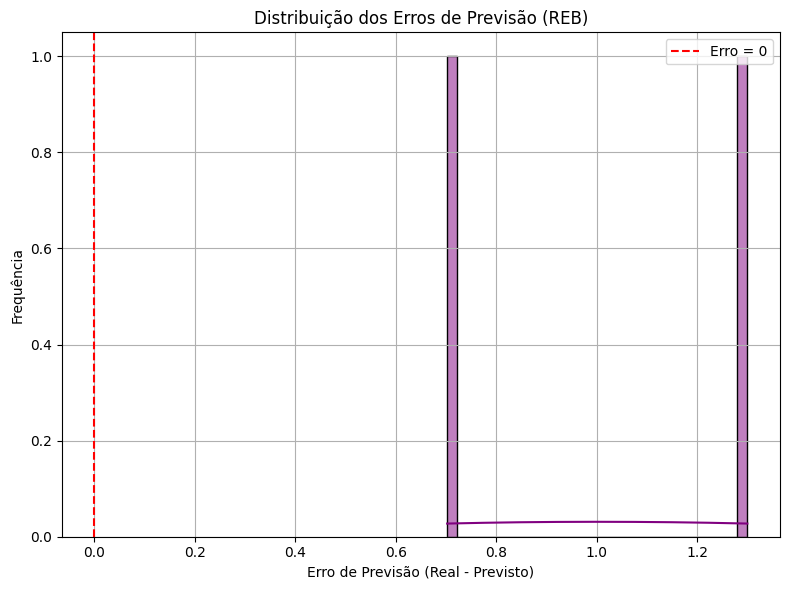

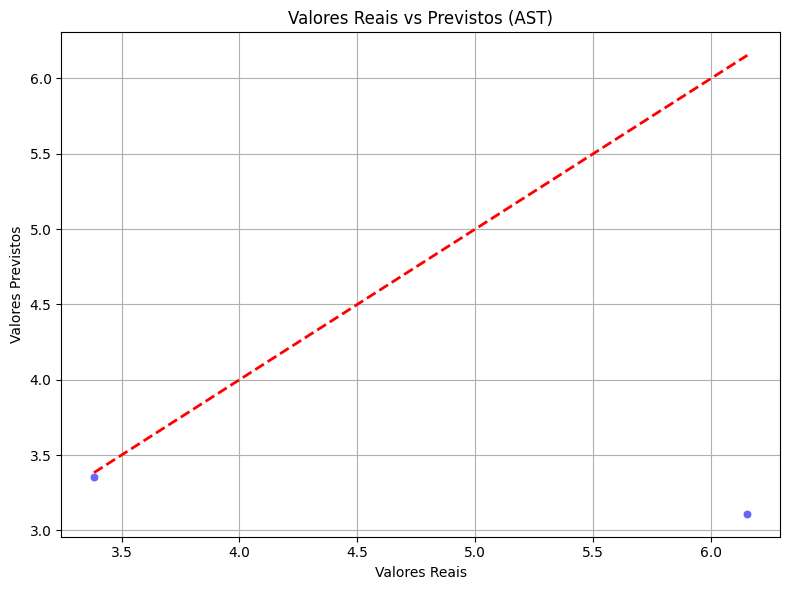

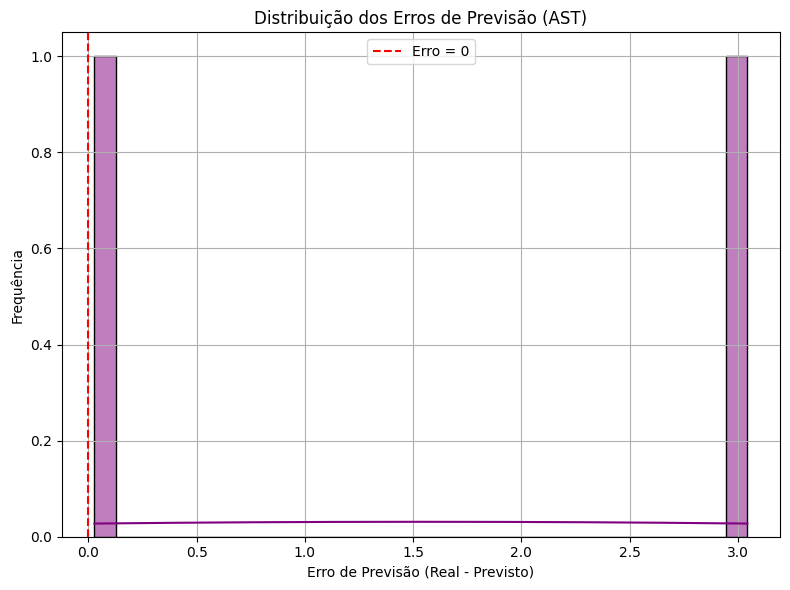

In [13]:
# Chamando as funções para cada métrica
feature_names = ['PLAYER_AGE', 'MIN', 'FG_PCT', 'GP']

# Gráficos para PTS
plot_real_vs_pred(y_test_pts, y_pred_pts, "PTS", JOGADOR_3)
plot_error_distribution(y_test_pts, y_pred_pts, "PTS", JOGADOR_3)


# Gráficos para REB
plot_real_vs_pred(y_test_reb, y_pred_reb, "REB", JOGADOR_3)
plot_error_distribution(y_test_reb, y_pred_reb, "REB", JOGADOR_3)


# Gráficos para AST
plot_real_vs_pred(y_test_ast, y_pred_ast, "AST", JOGADOR_3)
plot_error_distribution(y_test_ast, y_pred_ast, "AST", JOGADOR_3)
